In [1]:
import sys
sys.path.append('/home/lumargot/trachoma/src/py')

import os 
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1" # put -1 to not use any

In [2]:
import math
import pandas as pd
import numpy as np 

import matplotlib.pyplot as plt
import SimpleITK as sitk
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from evaluation import plot_confusion_matrix

from predict_outcome_height_analysis import compute_eye_bbx

In [3]:
df_predicted = pd.read_csv('/home/lumargot/trachoma/src/py/mtss_eyelid_prediction_for_analysis.csv')

In [4]:
df_annotation_surgeon = pd.read_csv('/CMF/data/lumargot/trachoma/PoPP_Data/mtss/Allsurgeonpredictions.csv',encoding='unicode_escape')

In [5]:
# 1) remove B grading
# df_annotation_surgeon = df_annotation_surgeon.loc[ df_annotation_surgeon['poppApp'] != 'B']

# df_annotation_surgeon = df_annotation_surgeon.loc[ df_annotation_surgeon['poppSX'] != 61]

/tmp/ipykernel_246407/3790979331.py:2: UserWarning: The palette list has more values (10) than needed (9), which may not be intended.
  sns.countplot(df_annotation_surgeon, x="poppApp", hue="poppSX", palette=sns.color_palette())


<Axes: xlabel='poppApp', ylabel='count'>

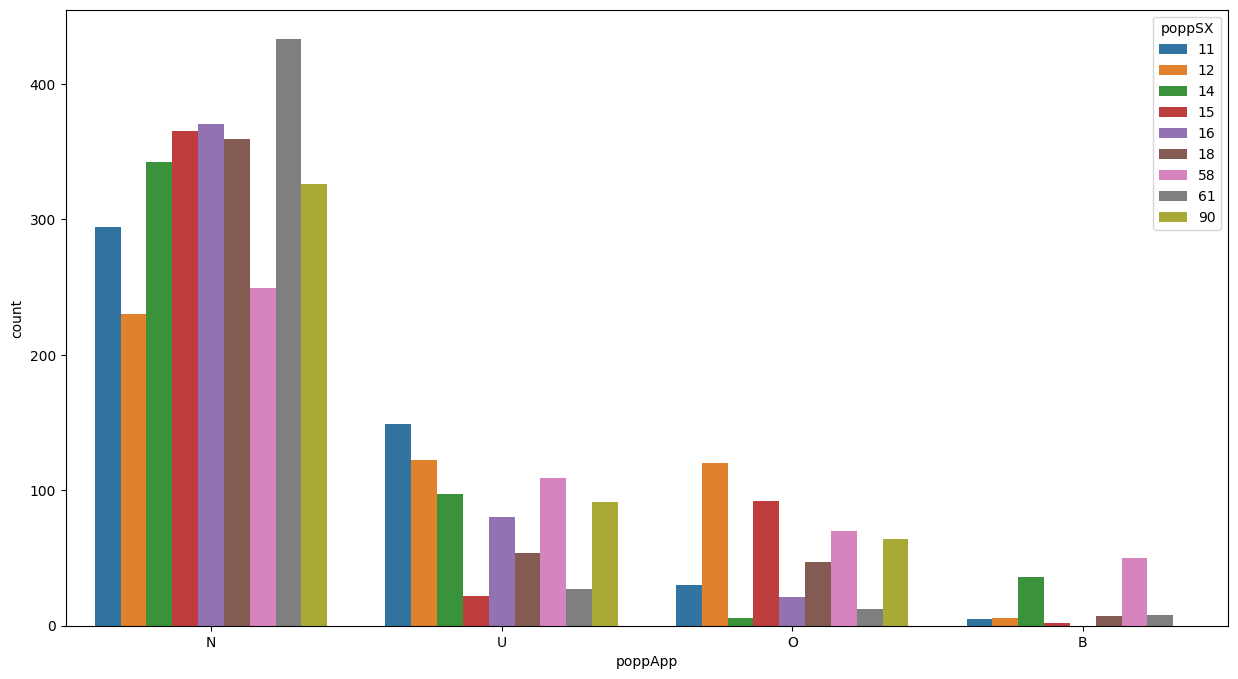

In [6]:
plt.figure(figsize=(15,8))
sns.countplot(df_annotation_surgeon, x="poppApp", hue="poppSX", palette=sns.color_palette())

In [7]:
def most_common(x):
    return x.mode().iat[0]  # .iat[0] handles ties by taking the first mode

In [10]:
surgeon_choices = np.unique(df_annotation_surgeon['poppSX'].to_numpy())

choice = 90
df_gold_standard = df_annotation_surgeon.loc[df_annotation_surgeon['poppSX']==choice]

# most common choices
# df_gold_standard = ( df_annotation_surgeon.groupby(['cid', 'eye'], as_index=False).agg({'poppApp': most_common}))
# choice = 'across_surgeon'

In [11]:
df_gold_standard.to_csv(f'outcome_gradint_surgeon{choice}.csv')

In [97]:
l_seg_path = []
l_cid = []
l_eye = []
l_gt = []
l_pred = []
l_isWavy = []
l_poppApp = []
l_outcome_gold = []
l_locations = []
l_probability = []
l_avg_correction = []

for idx, row in df_predicted.iterrows():
  cid, eye = int(row['cid']), row['eye']

  ##### section for gold standard 
  df_cid = df_gold_standard.loc[df_gold_standard['cid'] == cid]
  #####

  ###### section for average across surgeon
  df_cid_avg = df_annotation_surgeon.loc[df_annotation_surgeon['cid'] == cid]
  ######

  if len(df_cid) > 0:
    df_eye = df_cid.loc[df_cid['eye'] == eye.upper()]
    df_eye_avg = df_cid_avg.loc[df_cid_avg['eye'] == eye.upper()]

    if len(df_eye) > 0: 

      correction = df_eye['poppApp'].item()

      if choice != 'across_surgeon':
        correction, isPTT, isECA = df_eye['poppApp'].item(), df_eye['poppPTT'].item(), df_eye['poppECA'].item()

        if isPTT == 1.0 :
          if isECA == 1.0:
            l_outcome_gold.append(4)
          else:
            l_outcome_gold.append(1)
        if isECA == 1.0 :
          if isPTT == 1.0:
            l_outcome_gold.append(3)
          else:
            l_outcome_gold.append(2)
        if isECA == 0.0 and isPTT == 0:
            l_outcome_gold.append(0)
        
      if correction == 'O':
        l_poppApp.append(2)
      elif correction == 'U':
        l_poppApp.append(1)
      elif correction == 'N':
        l_poppApp.append(0)
      else:
        print("pb")

  
      l_seg_path.append(row['seg_path'])
      l_cid.append(row['cid'])
      l_eye.append(row['eye'])
      l_gt.append(row['gt'])
      l_pred.append(row['pred'])
      l_isWavy.append(row['isWavy'])
      l_locations.append(row['locations'])
      l_probability.append(row['probability'])

In [98]:
df_out = pd.DataFrame(data={'cid': l_cid,
                            'eye':l_eye,
                            'seg_path':l_seg_path,
                            'gt':l_gt, 
                            'pred':l_pred,
                           'locations':l_locations,
                           'isWavy':l_isWavy,
                           'probability':l_probability,
                            })

In [99]:
df_out[f'PoppApp_{choice}'] = l_poppApp
if choice != 'across_surgeon':
  df_out[f'PoppOutcome_{choice}'] = l_outcome_gold


              precision    recall  f1-score   support

           0       0.92      0.27      0.41       132
           1       0.36      0.74      0.48        19
           2       0.14      0.92      0.24        13

    accuracy                           0.37       164
   macro avg       0.47      0.64      0.38       164
weighted avg       0.79      0.37      0.41       164

Confusion matrix, without normalization
Normalized confusion matrix, avg: 0.6416901811638654


/tmp/ipykernel_240059/641052049.py:8: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(122)


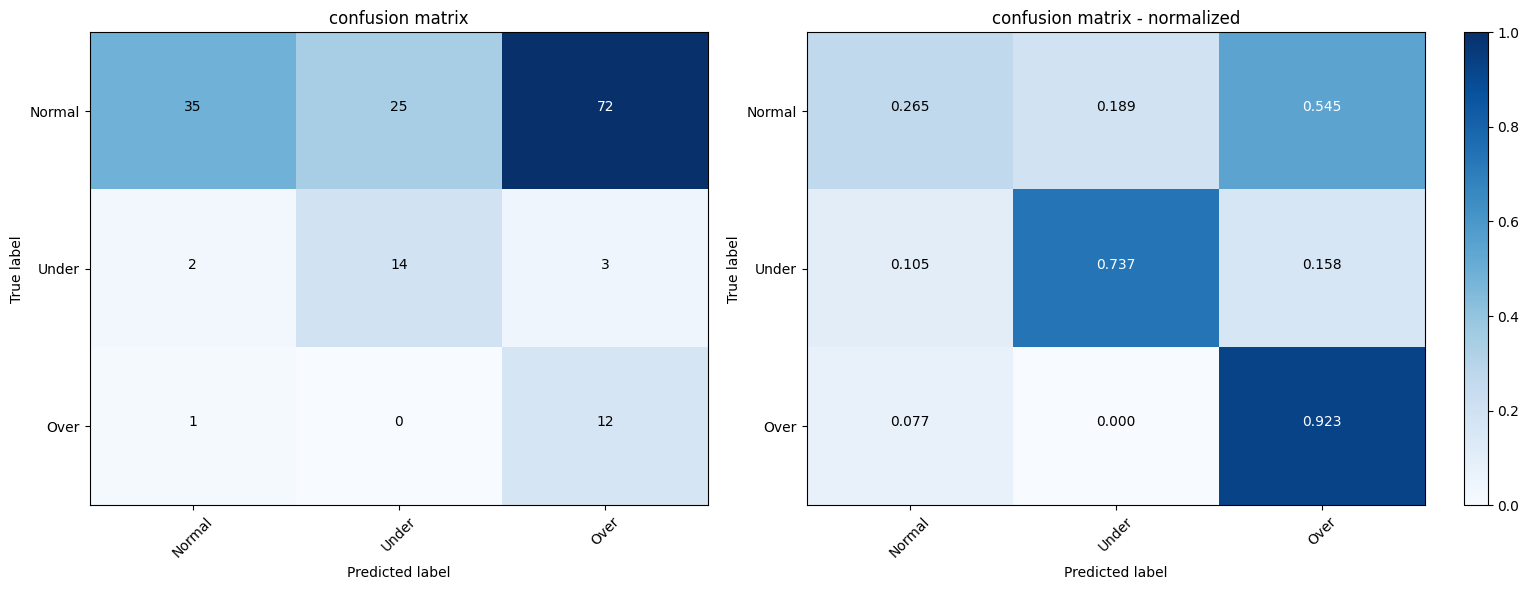

In [100]:
print(classification_report(df_out[f'PoppApp_{choice}'], df_out['pred'] ))
class_names = ['Normal', 'Under', 'Over']

fig = plt.figure(figsize=(16,6))
plt.subplot(121)
cnf_matrix = confusion_matrix(df_out[f'PoppApp_{choice}'], df_out['pred'])
plot_confusion_matrix(cnf_matrix, classes=class_names, title='confusion matrix')
plt.subplot(122)
cm = plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='confusion matrix - normalized')

In [ ]:
if choice != 'across_surgeon':

  print(classification_report(df_out[f'PoppOutcome_{choice}'], df_out['pred'] ))
  class_names = ['Normal', 'PTT', 'ECA']

  fig = plt.figure(figsize=(16,6))
  plt.subplot(121)
  cnf_matrix = confusion_matrix(df_out[f'PoppOutcome_{choice}'], df_out['pred'])
  plot_confusion_matrix(cnf_matrix, classes=class_names, title='confusion matrix')
  plt.subplot(122)
  cm = plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='confusion matrix - normalized')

### Visualize 'Both' outcome for surgeon 14

In [3]:
mount_point = '/CMF/data/lumargot/trachoma/PoPP_Data/mtss'
choice = 14

df_annotation_surgeon = pd.read_csv('/CMF/data/lumargot/trachoma/PoPP_Data/mtss/Allsurgeonpredictions.csv',encoding='unicode_escape')

df_surgeon_14_B = df_annotation_surgeon.loc[ df_annotation_surgeon['poppApp'] == 'B']
df_surgeon_14_B = df_surgeon_14_B.loc[df_surgeon_14_B['poppSX']==choice]


In [4]:
import torch

In [ ]:
delta=30
for idx, row in df_surgeon_14_B.iterrows():
  cid, eye = row['cid'], row['eye']

  img_name = f'img/{cid}_12Intra_{eye.lower()}_postop.jpg'
  seg_name = img_name.replace('img', 'segmentation_cleaned').replace('.jpg', '.nrrd')

  img = os.path.join(mount_point, img_name)
  seg = os.path.join(mount_point, seg_name)
  if os.path.exists(seg):

    img= sitk.GetArrayFromImage(sitk.ReadImage(img)).copy()
    seg_t = torch.tensor(sitk.GetArrayFromImage(sitk.ReadImage(seg)).copy())
    bb = compute_eye_bbx(seg_t)
    plt.figure(figsize=(12,5))
    plt.subplot(121)
    plt.imshow(img[bb[1]-delta:bb[3]+delta,bb[0]-delta:bb[2]+delta])

    if len(np.unique(seg_t)) == 2: ## contain only eyelid 
      image_mask = seg_t.float()
        
    else:# if contain entire eye seg_tmented
      image_mask = (seg_t == 3).float()
    image_mask = image_mask[bb[1]-delta:bb[3]+delta,bb[0]-delta:bb[2]+delta]

    plt.subplot(122)
    plt.title('cropped seg')
    plt.imshow(image_mask)

    plt.tight_layout()
    plt.show()  